## 1. Importing Libraries

In [2]:
import os
import sys
module_path = "../03.src"
if module_path not in sys.path:
    sys.path.append(module_path)
    
# 1. General Libraries
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import wandb
import csv
from tqdm.notebook import tqdm
from skimage import io
from skimage.color import gray2rgb
DATA_PATH = '../data/higher_modality_vol1.csv'

## 2. Functions

In [3]:
def show_batch_images(route ='/mnt/subfigure-classification/2016/train',class_name = 'GFIG',rows = 2,cols = 4):
    images = os.listdir(os.path.join(route,class_name))
    row = rows; col = cols;
    plt.figure(figsize=(20,(row/col)*12))
    plt.suptitle(f"{class_name} images",  y=1.05, fontsize=30)
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        img = os.path.join(route,class_name,images[j])
        img = io.imread(img)
        if len(img.shape) == 2:
            img = gray2rgb(img)
        else:
            img = img[:, :, :3]
        plt.imshow(img)
        plt.title(f'Image {class_name}')
    plt.tight_layout()
    plt.show()

## 3 Visualization of the Classes & Datasets

### Graphics Classifier
+ GFIG:  Statistical figures, graphs, charts
+ GFLO : Flowcharts
+ DSEM : Electromyography
+ DSEE : Electroencephalography
+ DSEC : Electrocardiography

In [4]:
df = pd.read_csv(DATA_PATH,sep = '\t')
df[df['higher_modality']=='GRAPHICS']['modality'].unique()

array(['GFIG', 'GFLO', 'DSEM', 'DSEE', 'DSEC'], dtype=object)

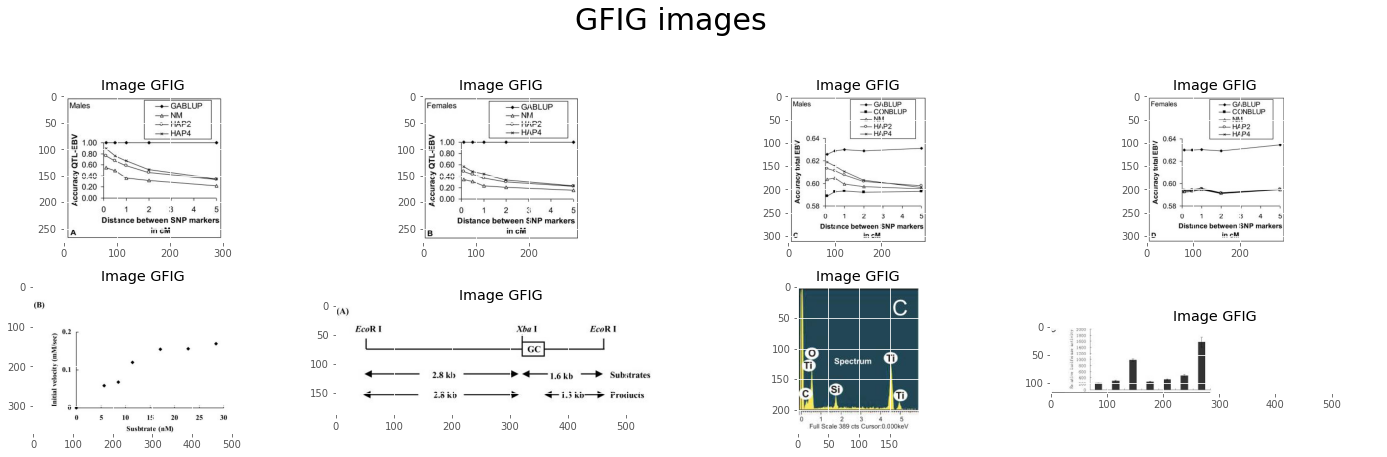

In [7]:
show_batch_images(class_name='GFIG')

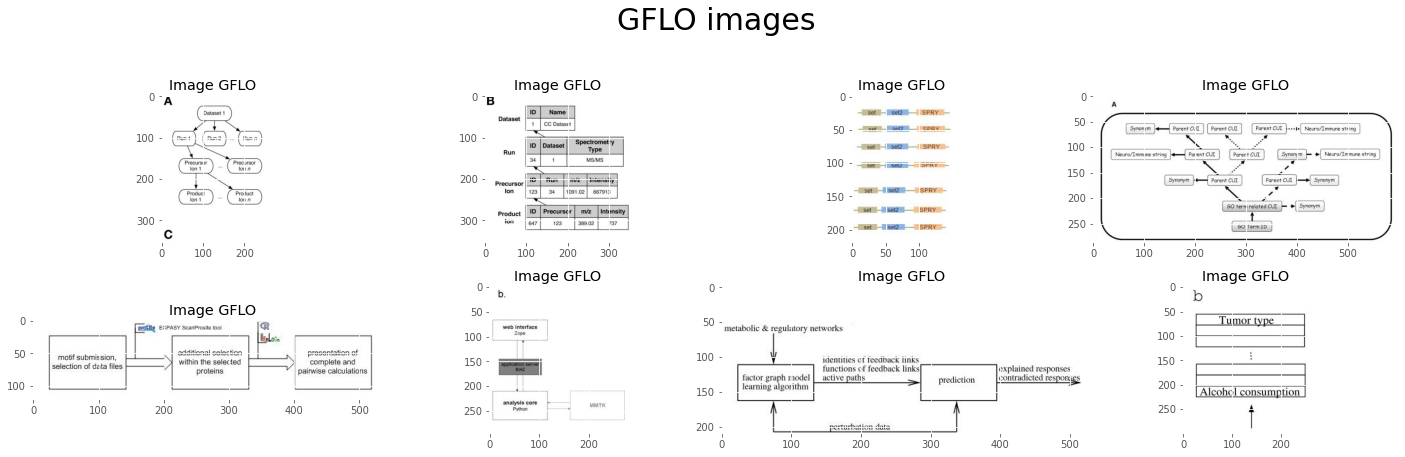

In [8]:
show_batch_images(class_name='GFLO')

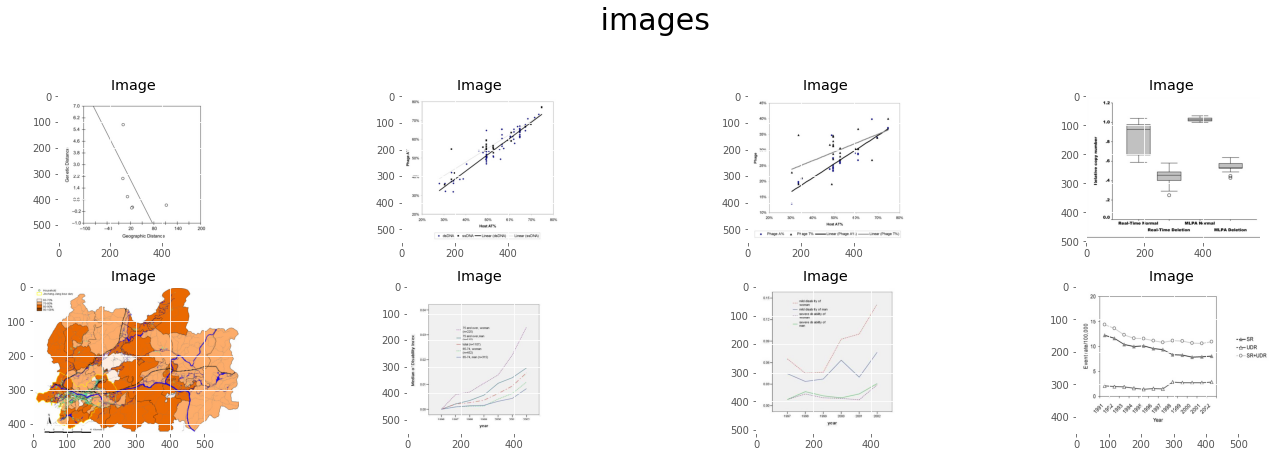

In [9]:
route_ = '/mnt/chart_icpr2020/ICPR2020_CHARTINFO_UB_PMC_TEST_v1.0/splits_with_GT/split_1/images'
show_batch_images(route =route_,class_name = '',rows = 2,cols = 4)

## 5. Write Csv Files 

### 5.1 Synthetic Dataset Train

In [2]:
# ===============================================
# 1. Write CSV File for chart_synthetic Dataset
# ===============================================
OUTPUT_PATH ='../data/chart_synthetic_train.csv'
with open(OUTPUT_PATH, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['ID', 'img', 'img_path', 'modality', 'higher_modality'])
    i = 1
    for json_file in tqdm(os.listdir('/mnt/chart_synthetic_1/json_gt/')):
        json_file_route  = os.path.join('/mnt/chart_synthetic_1/json_gt/',json_file)
        modality         = pd.read_json(json_file_route)['task1']['output']['chart_type']
        try: 
            image_name = json_file.replace('json','png')
            img_path   = os.path.join('chart_synthetic_1/train',image_name)
            img_ = io.imread(os.path.join('/mnt',img_path))        
            row = [i, image_name, img_path, modality, 'GRAPHICS']
            writer.writerow(row)
            i += 1
        except:
            print(f"Error {json_file} not found" )

### 5.1 Chart2020 Dataset Train

In [16]:
# ===============================================
# 1. Write CSV File for Chart2020 Dataset
# ===============================================
OUTPUT_PATH ='../data/chart_2020_train.csv'
def csv_file_chart2020_train(OUTPUT_PATH):
    df = None
    for i in os.listdir('/mnt/chart_icpr2020/ICPR2020_CHARTINFO_UB_PMC_TRAIN_v1.21/images/'):
        ruta_image_class = os.path.join('/mnt/chart_icpr2020/ICPR2020_CHARTINFO_UB_PMC_TRAIN_v1.21/images/',i)
        images     = os.listdir(ruta_image_class)
        image_path = [os.path.join('chart_icpr2020/ICPR2020_CHARTINFO_UB_PMC_TRAIN_v1.21/images/',i,j) for j in images]
        df_actual  = pd.DataFrame({'img':images,'img_path':image_path})
        df_actual['modality']  =  i
        df_actual['higher_modality']  =  'GRAPHICS'
        df = pd.concat([df,df_actual])
        df.to_csv(OUTPUT_PATH,index = False)
csv_file_chart2020_train(OUTPUT_PATH)

## 6. Building Dataset For Training

In [5]:
df_chart_synthetic = pd.read_csv('../data/chart_synthetic_train.csv')
df_chart_synthetic['source']  = 'Chart_Synthetic'

df_chart_2020      = pd.read_csv('../data/chart_2020_train.csv')
df_chart_2020['source'] = 'Chart2020'
df_clef            = pd.read_csv(DATA_PATH,sep = '\t')
df_clef            = df_clef[df_clef['higher_modality']=='GRAPHICS'].reset_index(drop = True)
df_clef            = df_clef[df_clef['modality'].isin(['GFLO'])].reset_index(drop = True)

# Making a copy of the columns
def copy_(df):
    df['original'] = df['modality']

copy_(df_chart_synthetic)
copy_(df_chart_2020)
copy_(df_clef)

print(f"Chart Synthetic: {df_chart_synthetic.shape}")
print(f"Chart 2020:      {df_chart_2020.shape}")
print(f"CLEF 2016:       {df_clef.shape}")

Chart Synthetic: (198010, 7)
Chart 2020:      (15636, 6)
CLEF 2016:       (144, 9)


### 6.1 Mapping  images to the respective class
- histogram
- scatterplot
- graphs
- heatmap
- other
- Line Charts


In [6]:
dict_chart_synthetic = {'Scatter':'scatterplot',
                       'Grouped horizontal bar':'histogram',
                       'Grouped vertical bar':'histogram',
                       'Horizontal box':'other',
                       'Vertical box':'other',
                       'Stacked horizontal bar':'histogram',
                       'Stacked vertical bar':'histogram',
                       'Line':'Lineplots',
                       'Pie':'other',
                       'Donut':'other'}

dict_chart_2020 = {'area':'other',
                  'heatmap':'heatmap',
                  'horizontal_bar':'histogram',
                   'horizontal_interval':'other',
                   'line':'Lineplots',
                   'manhattan':'other',
                   'map':'other',
                   'pie':'other',
                   'scatter':'scatterplot',
                   'scatter-line':'scatterplot',
                   'surface':'other',
                   'venn':'other',
                   'vertical_bar':'histogram',
                   'vertical_box':'other',
                   'vertical_interval':'other'}

dict_clef = {'GFLO':'graph'}

# Combining all the datasets
columns = ['img','original','modality','source','img_path','higher_modality']
df_chart_synthetic['modality'] = df_chart_synthetic['modality'].replace(dict_chart_synthetic)
df_chart_2020['modality']      = df_chart_2020['modality'].replace(dict_chart_2020)
df_clef['modality']            = df_clef['modality'].replace(dict_clef)
df_graphics = pd.concat([df_chart_synthetic[columns],df_chart_2020[columns],df_clef[columns]],axis = 0).reset_index(drop = True)


In [7]:
pd.crosstab(df_graphics['original'],df_graphics['modality'])

modality,Lineplots,graph,heatmap,histogram,other,scatterplot
original,,,,,,
Donut,0,0,0,0,21202,0
GFLO,0,144,0,0,0,0
Grouped horizontal bar,0,0,0,8586,0,0
Grouped vertical bar,0,0,0,8560,0,0
Horizontal box,0,0,0,0,21007,0
Line,41874,0,0,0,0,0
Pie,0,0,0,0,7001,0
Scatter,0,0,0,0,0,41703
Stacked horizontal bar,0,0,0,13718,0,0


In [8]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
mskf = MultilabelStratifiedKFold(n_splits = 5, shuffle = False)
for fold,(train_index, test_index) in enumerate(mskf.split(df_graphics, df_graphics[['modality','source']])):
    if fold == 0:   
        df_graphics.loc[test_index,'split_set'] = 'TEST'
        df_graphics.loc[train_index,'split_set'] = 'TRAIN'

df_graphics.loc[df_graphics['original']=='GFLO','img_path'] = 'subfigure-classification/' + df_graphics['img_path']

mskf = MultilabelStratifiedKFold(n_splits = 5, shuffle = False)

df_graphics_train = df_graphics[df_graphics['split_set']=='TRAIN'].reset_index(drop = True)
df_graphics_test  = df_graphics[df_graphics['split_set']=='TEST'].reset_index(drop = True)
for fold,(train_index, test_index) in enumerate(mskf.split(df_graphics_train, df_graphics_train[['modality','source']])):
    if fold == 0:   
        df_graphics_train.loc[test_index,'split_set'] = 'VAL'
        df_graphics_train.loc[train_index,'split_set'] = 'TRAIN'

df_graphics_concat = pd.concat([df_graphics_train,df_graphics_test],axis = 0).reset_index(drop = True)
df_graphics_concat.to_csv('../data/graphics_dataset_final_v1.csv',sep = '\t',index = False)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass shuffle=False, random_state=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass shuffle=False, random_state=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [10]:
df_graphics_concat[df_graphics_concat['original']=='GFLO']

,img,original,modality,source,img_path,higher_modality,split_set
170917,1471-2105-10-254-5-1.jpg,GFLO,graph,clef16,subfigure-classification/2016/train/GFLO/1471-...,GRAPHICS,TRAIN
170918,1471-2105-10-298-1-3.jpg,GFLO,graph,clef16,subfigure-classification/2016/train/GFLO/1471-...,GRAPHICS,TRAIN
170919,1471-2105-11-458-4-1.jpg,GFLO,graph,clef16,subfigure-classification/2016/train/GFLO/1471-...,GRAPHICS,TRAIN
170920,1471-2105-6-52-1-2.jpg,GFLO,graph,clef16,subfigure-classification/2016/train/GFLO/1471-...,GRAPHICS,TRAIN
170921,1471-2105-7-332-1-2.jpg,GFLO,graph,clef16,subfigure-classification/2016/train/GFLO/1471-...,GRAPHICS,TRAIN
...,...,...,...,...,...,...,...
213785,1742-4690-2-18-1.jpg,GFLO,graph,clef13,subfigure-classification/2013/train/GFLO/1742-...,GRAPHICS,TEST
213786,1745-6215-10-20-1.jpg,GFLO,graph,clef13,subfigure-classification/2013/train/GFLO/1745-...,GRAPHICS,TEST
213787,1748-5908-6-53-1.jpg,GFLO,graph,clef13,subfigure-classification/2013/train/GFLO/1748-...,GRAPHICS,TEST
213788,1755-7682-3-22-1.jpg,GFLO,graph,clef13,subfigure-classification/2013/train/GFLO/1755-...,GRAPHICS,TEST


In [89]:
df_graphics_concat['split_set'].value_counts()

TRAIN    136825
TEST      42758
VAL       34207
Name: split_set, dtype: int64